In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn import preprocessing
import os
%matplotlib inline

C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
# load the data
all_slices = np.load(os.path.join("data", "all_slices.npy"))
all_labels = np.load(os.path.join("data", "all_labels.npy"))

normal_slices_0 = np.load(os.path.join("data", "image_batch_0.npy"))
normal_labels_0 = np.load(os.path.join("data", "label_batch_0.npy"))

normal_slices_1 = np.load(os.path.join("data", "image_batch_1.npy"))
normal_labels_1 = np.load(os.path.join("data", "label_batch_1.npy"))

normal_slices_2 = np.load(os.path.join("data", "image_batch_2.npy"))
normal_labels_2 = np.load(os.path.join("data", "label_batch_2.npy"))

normal_slices_3 = np.load(os.path.join("data", "image_batch_3.npy"))
normal_labels_3 = np.load(os.path.join("data", "label_batch_3.npy"))

normal_slices_4 = np.load(os.path.join("data", "image_batch_4.npy"))
normal_labels_4 = np.load(os.path.join("data", "label_batch_4.npy"))

# concatenate all the data and shuffle it
all_images = np.concatenate([all_slices, normal_slices_0, normal_slices_1, normal_slices_2, normal_slices_3, normal_slices_4], axis=0)
all_labels = np.concatenate([all_labels, normal_labels_0, normal_labels_1, normal_labels_2, normal_labels_3, normal_labels_4], axis=0)

print("All images:", all_images.shape)
print("All labels:", all_labels.shape)

In [3]:
# encode the labels
le = preprocessing.LabelEncoder()
le.fit(all_labels)
# we want normal to be 0, so we'll do some transformations here
labels_enc = le.transform(all_labels) + 1
labels_enc[labels_enc == 5] = 0

# make the classes be in the same order as the labels
classes = le.classes_
classes = np.insert(classes, 0, 'NORMAL', axis=0)
classes = classes[0:5]

# make some other labels
labels_normal = np.zeros(len(labels_enc)).astype(np.int32)
labels_normal[labels_enc != 0] = 1

labels_mass = np.zeros(len(labels_enc)).astype(np.int32)
labels_mass[labels_enc == 1] = 1
labels_mass[labels_enc == 3] = 1
labels_mass[labels_enc == 2] = 2
labels_mass[labels_enc == 4] = 2

labels_benign = np.zeros(len(labels_enc)).astype(np.int32)
labels_benign[labels_enc == 1] = 1
labels_benign[labels_enc == 2] = 1
labels_benign[labels_enc == 3] = 2
labels_benign[labels_enc == 4] = 2

np.save(os.path.join("data", "all_classes.npy"), classes)

In [4]:
pd.value_counts(labels_benign, normalize=True)

0    0.850473
1    0.076400
2    0.073127
dtype: float64

In [5]:
pd.value_counts(labels_mass, normalize=True)

0    0.850473
1    0.082291
2    0.067236
dtype: float64

In [6]:
pd.value_counts(labels_normal, normalize=True)

0    0.850473
1    0.149527
dtype: float64

In [5]:
from sklearn.model_selection import train_test_split

# Split data into training and test 
X_tr, X_te, y_tr, y_te, labels_normal_tr, labels_normal_te, labels_mass_tr, labels_mass_te, labels_benign_tr, labels_benign_te = train_test_split(all_images, labels_enc, labels_normal, labels_mass, labels_benign, test_size=0.2, random_state=3455)

In [6]:
print("X_tr", X_tr.shape)
print("X_te", X_te.shape)

X_tr (22000, 299, 299, 1)
X_te (5500, 299, 299, 1)


In [7]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [10]:
# write train data to tfrecords in 4 batches
import math
batch_size = math.ceil(X_tr.shape[0] / 4)

for i in range(4):
    train_path = os.path.join("data","training_" + str(i) + '.tfrecords')
    writer = tf.python_io.TFRecordWriter(train_path)
    start_row = i * batch_size
    end_row = start_row + batch_size - 1
                              
    for idx in range(start_row, end_row):
        label = y_tr[idx]
        label_normal = labels_normal_tr[idx]
        label_mass = labels_mass_tr[idx]
        label_benign = labels_benign_tr[idx]
        image = X_tr[idx]
        image_raw = image.tostring()

        example = tf.train.Example(
            features=tf.train.Features(
              feature={
                # A Feature contains one of either a int64_list,
                # float_list, or bytes_list
                'label': _int64_feature(label),
                'label_normal': _int64_feature(label_normal),
                'label_mass': _int64_feature(label_mass),
                'label_benign': _int64_feature(label_benign),
                'image': _bytes_feature(image_raw),
              }))

        # use the proto object to serialize the example to a string
        serialized = example.SerializeToString()
        # write the serialized object to disk
        writer.write(serialized)

In [8]:
# save the test data and labels to npy files
np.save(os.path.join("data", "test_data.npy"), X_te)
np.save(os.path.join("data", "test_labels.npy"), y_te)

In [12]:
# write test data to tfrecords 
test_path = os.path.join("data","test.tfrecords")
writer = tf.python_io.TFRecordWriter(test_path)

for idx in range(X_te.shape[0]):
    label = y_te[idx]
    label_normal = labels_normal_te[idx]
    label_mass = labels_mass_te[idx]
    label_benign = labels_benign_te[idx]
    image = X_te[idx]
    image_raw = image.tostring()
    
    example = tf.train.Example(
        features=tf.train.Features(
          feature={
            'label': _int64_feature(label),
            'label_normal': _int64_feature(label_normal),
            'label_mass': _int64_feature(label_mass),
            'label_benign': _int64_feature(label_benign),
            'image': _bytes_feature(image_raw),
          }))
    
    serialized = example.SerializeToString()
    writer.write(serialized)

In [3]:
# make sure everything was written properly by reading it back out
def read_and_decode_single_example(filenames):
    filename_queue = tf.train.string_input_producer(filenames, num_epochs=1)
    
    reader = tf.TFRecordReader()
    
    _, serialized_example = reader.read(filename_queue)
    # The serialized example is converted back to actual values.
    # One needs to describe the format of the objects to be returned
    features = tf.parse_single_example(
        serialized_example,
        features={
            # We know the length of both fields. If not the
            # tf.VarLenFeature could be used
            'label': tf.FixedLenFeature([], tf.int64),
            'image': tf.FixedLenFeature([], tf.string)
        })
    
    # now return the converted data
    label = features['label']
    image = tf.decode_raw(features['image'], tf.uint8)
    image = tf.reshape(image, [299, 299, 1])
    
    # scale the image
    image = tf.image.per_image_standardization(image)
    
    return label, image

In [4]:
label, image = read_and_decode_single_example(["data/training_0.tfrecords", "data/training_1.tfrecords"])

images_batch, labels_batch = tf.train.shuffle_batch([image, label], batch_size=16, capacity=2000, min_after_dequeue=1000)

global_step = tf.Variable(0, trainable=False)

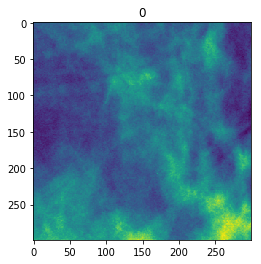

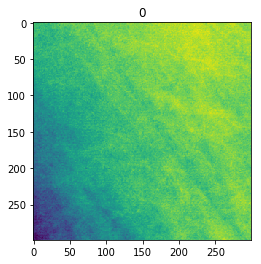

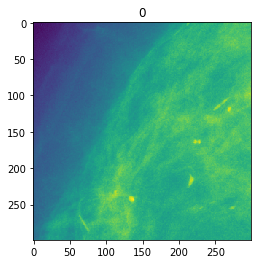

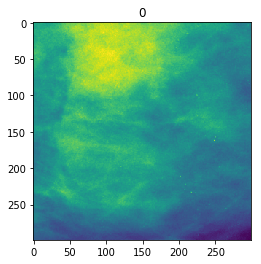

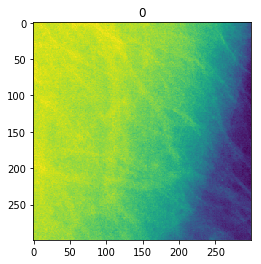

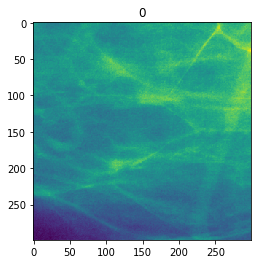

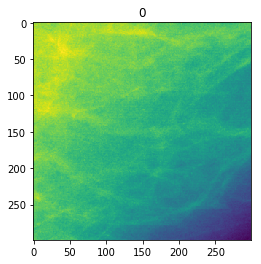

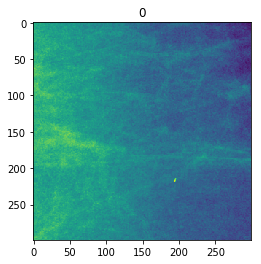

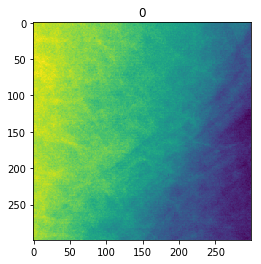

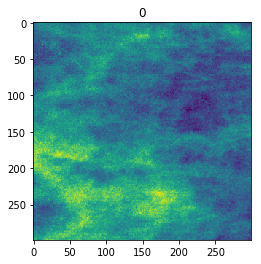

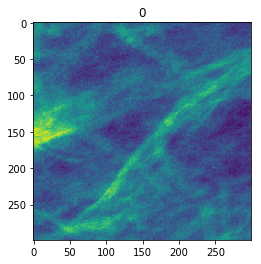

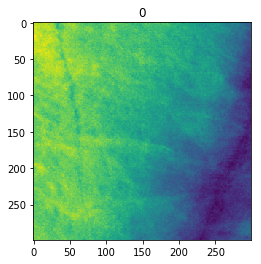

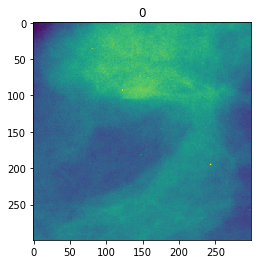

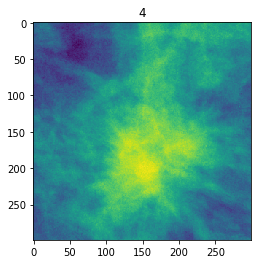

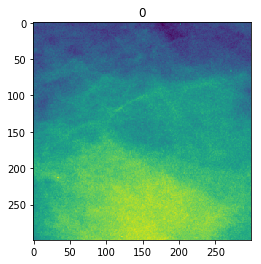

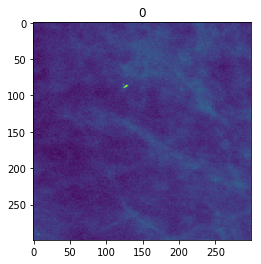

In [5]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    la_b, im_b = sess.run([labels_batch, images_batch])
    
    
    for i in range(16):
        plt.imshow(im_b[i].reshape([299,299]))
        plt.title(la_b[i])
        plt.show()
    
    coord.request_stop()
    
    # Wait for threads to stop
    coord.join(threads)
    